In [3]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
N = norm.cdf


def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T) * N(d2)


def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)


def implied_vol(opt_value, S, K, T, r, type_='call'):

    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)

    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)

    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01, 6), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01, 6),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")


In [20]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    
    if return_vol:
        return prices, sigs
    
    return prices

Text(0, 0.5, 'Density')

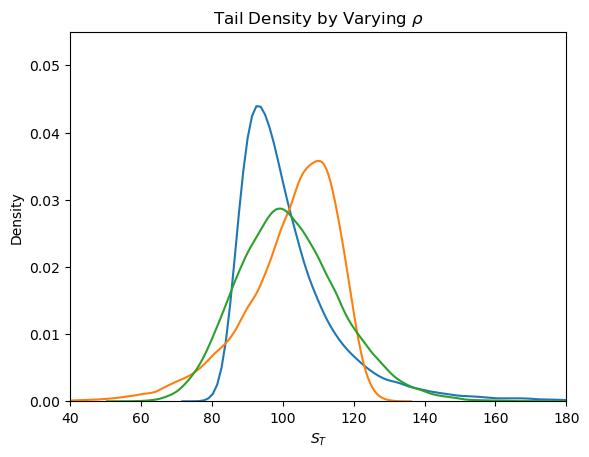

In [18]:
import seaborn as sns
kappa = 4
theta = 0.02
v_0 = 0.02
xi = 0.5
r = 0.02
S = 100
paths = 50000
steps = 2000
T = 1

prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                   v_0, rho=0.9, xi=xi, steps=steps, Npaths=paths,
                                   return_vol=False)[:, -1]
prices_neg = generate_heston_paths(S, T, r, kappa, theta,
                                   v_0, rho=-0.9, xi=xi, steps=steps, Npaths=paths,
                                   return_vol=False)[:, -1]
gbm_bench = S*np.exp(np.random.normal((r - v_0/2)*T,
                                      np.sqrt(theta)*np.sqrt(T), size=paths))


fig, ax = plt.subplots()

ax = sns.kdeplot(data=prices_pos, label=r"$\rho = 0.9$", ax=ax)
ax = sns.kdeplot(data=prices_neg, label=r"$\rho= -0.9$ ", ax=ax)
ax = sns.kdeplot(data=gbm_bench, label="GBM", ax=ax)

ax.set_title(r'Tail Density by Varying $\rho$')
plt.axis([40, 180, 0, 0.055])
plt.xlabel('$S_T$')
plt.ylabel('Density')


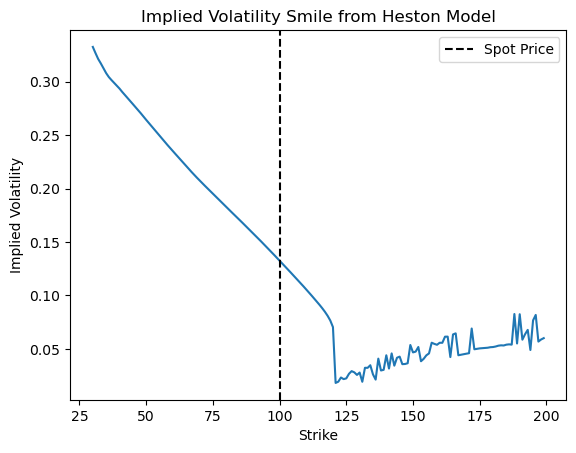

In [41]:
strikes =np.arange(30, 200,1)

puts = [] 

for K in strikes:
    P = np.mean(np.maximum(K-prices_neg,0))*np.exp(-r*T)
    puts.append(P)


ivs = [implied_vol(P, S, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]

plt.plot(strikes, ivs)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S, color='black',linestyle='--',
            label='Spot Price')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()

In [36]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from datetime import datetime
from scipy.interpolate import griddata

# Define the symbol of the underlying asset

symbol = "TSLA"  # Replace with the desired stock symbol

#aapl

# expi = ['2023-05-26', '2023-06-02', '2023-06-09', '2023-06-16', '2023-06-23', '2023-06-30', '2023-07-21', '2023-08-18', '2023-09-15', '2023-10-20', '2023-11-17', '2023-12-15', '2024-01-19', '2024-03-15', '2024-06-21', '2024-09-20', '2024-12-20', '2025-01-17', '2025-06-20', '2025-12-19']

expi = ['2023-05-26', '2023-06-02', '2023-06-09', '2023-06-16', '2023-06-23', '2023-06-30', '2023-07-21', '2023-08-18', '2023-09-15', '2023-10-20', '2023-11-17', '2023-12-15', '2024-01-19', '2024-03-15', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19']
#AMZN
# expi = ['2023-05-12', '2023-05-19', '2023-05-26', '2023-06-02', '2023-06-09', '2023-06-16', '2023-06-23', '2023-07-21', '2023-08-18', '2023-09-15', '2023-10-20', '2024-01-19', '2024-03-15', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19']

opt = []

for i in expi:
    # Retrieve the option chain data' using yfinance
    stock = yf.Ticker(symbol)
    op = stock.option_chain(i)
    opt.append(op.calls)

option_chain = pd.concat(opt)

# Access the strike prices and expiration dates from the option chain
strikes = option_chain.strike.values
prices = option_chain.ask.values
expirations = pd.DataFrame()

 

expirations["year"] = "20" + option_chain.contractSymbol.str[4:6]
expirations["month"] = option_chain.contractSymbol.str[6:8]
expirations["day"] = option_chain.contractSymbol.str[8:10]

expirations["date"] = pd.to_datetime(dict(year=expirations.year, month=expirations.month, day=expirations.day))
expirations["date"] = expirations["date"].values.astype(np.int64) // 10**9


In [38]:
option_chain

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA230526C00020000,2023-05-19 14:53:52+00:00,20.0,159.87,158.85,161.00,5.889999,3.825172,1.0,2,8.726567,True,REGULAR,USD
1,TSLA230526C00030000,2023-05-05 15:55:58+00:00,30.0,138.52,148.85,151.00,0.000000,0.000000,1.0,2,7.058595,True,REGULAR,USD
2,TSLA230526C00040000,2023-05-05 15:29:21+00:00,40.0,128.60,138.85,141.05,0.000000,0.000000,1.0,1,5.992190,True,REGULAR,USD
3,TSLA230526C00050000,2023-05-19 13:43:51+00:00,50.0,128.99,128.85,131.05,6.100006,4.963794,2.0,82,5.132816,True,REGULAR,USD
4,TSLA230526C00070000,2023-05-19 13:58:28+00:00,70.0,109.21,108.90,111.15,109.210000,NaN,5.0,0,3.942383,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,TSLA251219C00350000,2023-05-19 19:54:37+00:00,350.0,23.90,23.35,25.00,0.949999,4.139429,31.0,1062,0.519170,False,REGULAR,USD
51,TSLA251219C00360000,2023-05-19 18:51:42+00:00,360.0,22.85,22.35,23.95,1.250000,5.787037,4.0,208,0.519811,False,REGULAR,USD
52,TSLA251219C00370000,2023-05-18 15:18:45+00:00,370.0,20.50,21.30,22.95,0.000000,0.000000,51.0,268,0.519902,False,REGULAR,USD
53,TSLA251219C00380000,2023-05-19 14:46:50+00:00,380.0,21.51,20.20,21.90,2.210001,11.450783,18.0,391,0.518956,False,REGULAR,USD


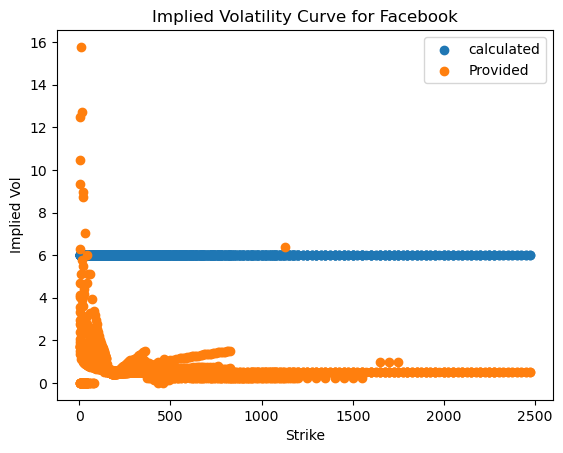

In [40]:
i = 0
ivs = []
for row in option_chain.itertuples():
    iv = implied_vol(row.ask, row.lastPrice, row.strike, expirations["date"].iloc[i], 0.02)
    ivs.append(iv)
    i+=1


plt.scatter(option_chain.strike, ivs, label='calculated')
plt.scatter(option_chain.strike, option_chain.impliedVolatility, label='Provided')
plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.title('Implied Volatility Curve for Facebook')
plt.legend() 

In [39]:
ivs

[5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.999994993